## Topic Modeling Analysis of Tripadvisor Hotel Reviews with Latent Dirichlet Allocation (LDA)

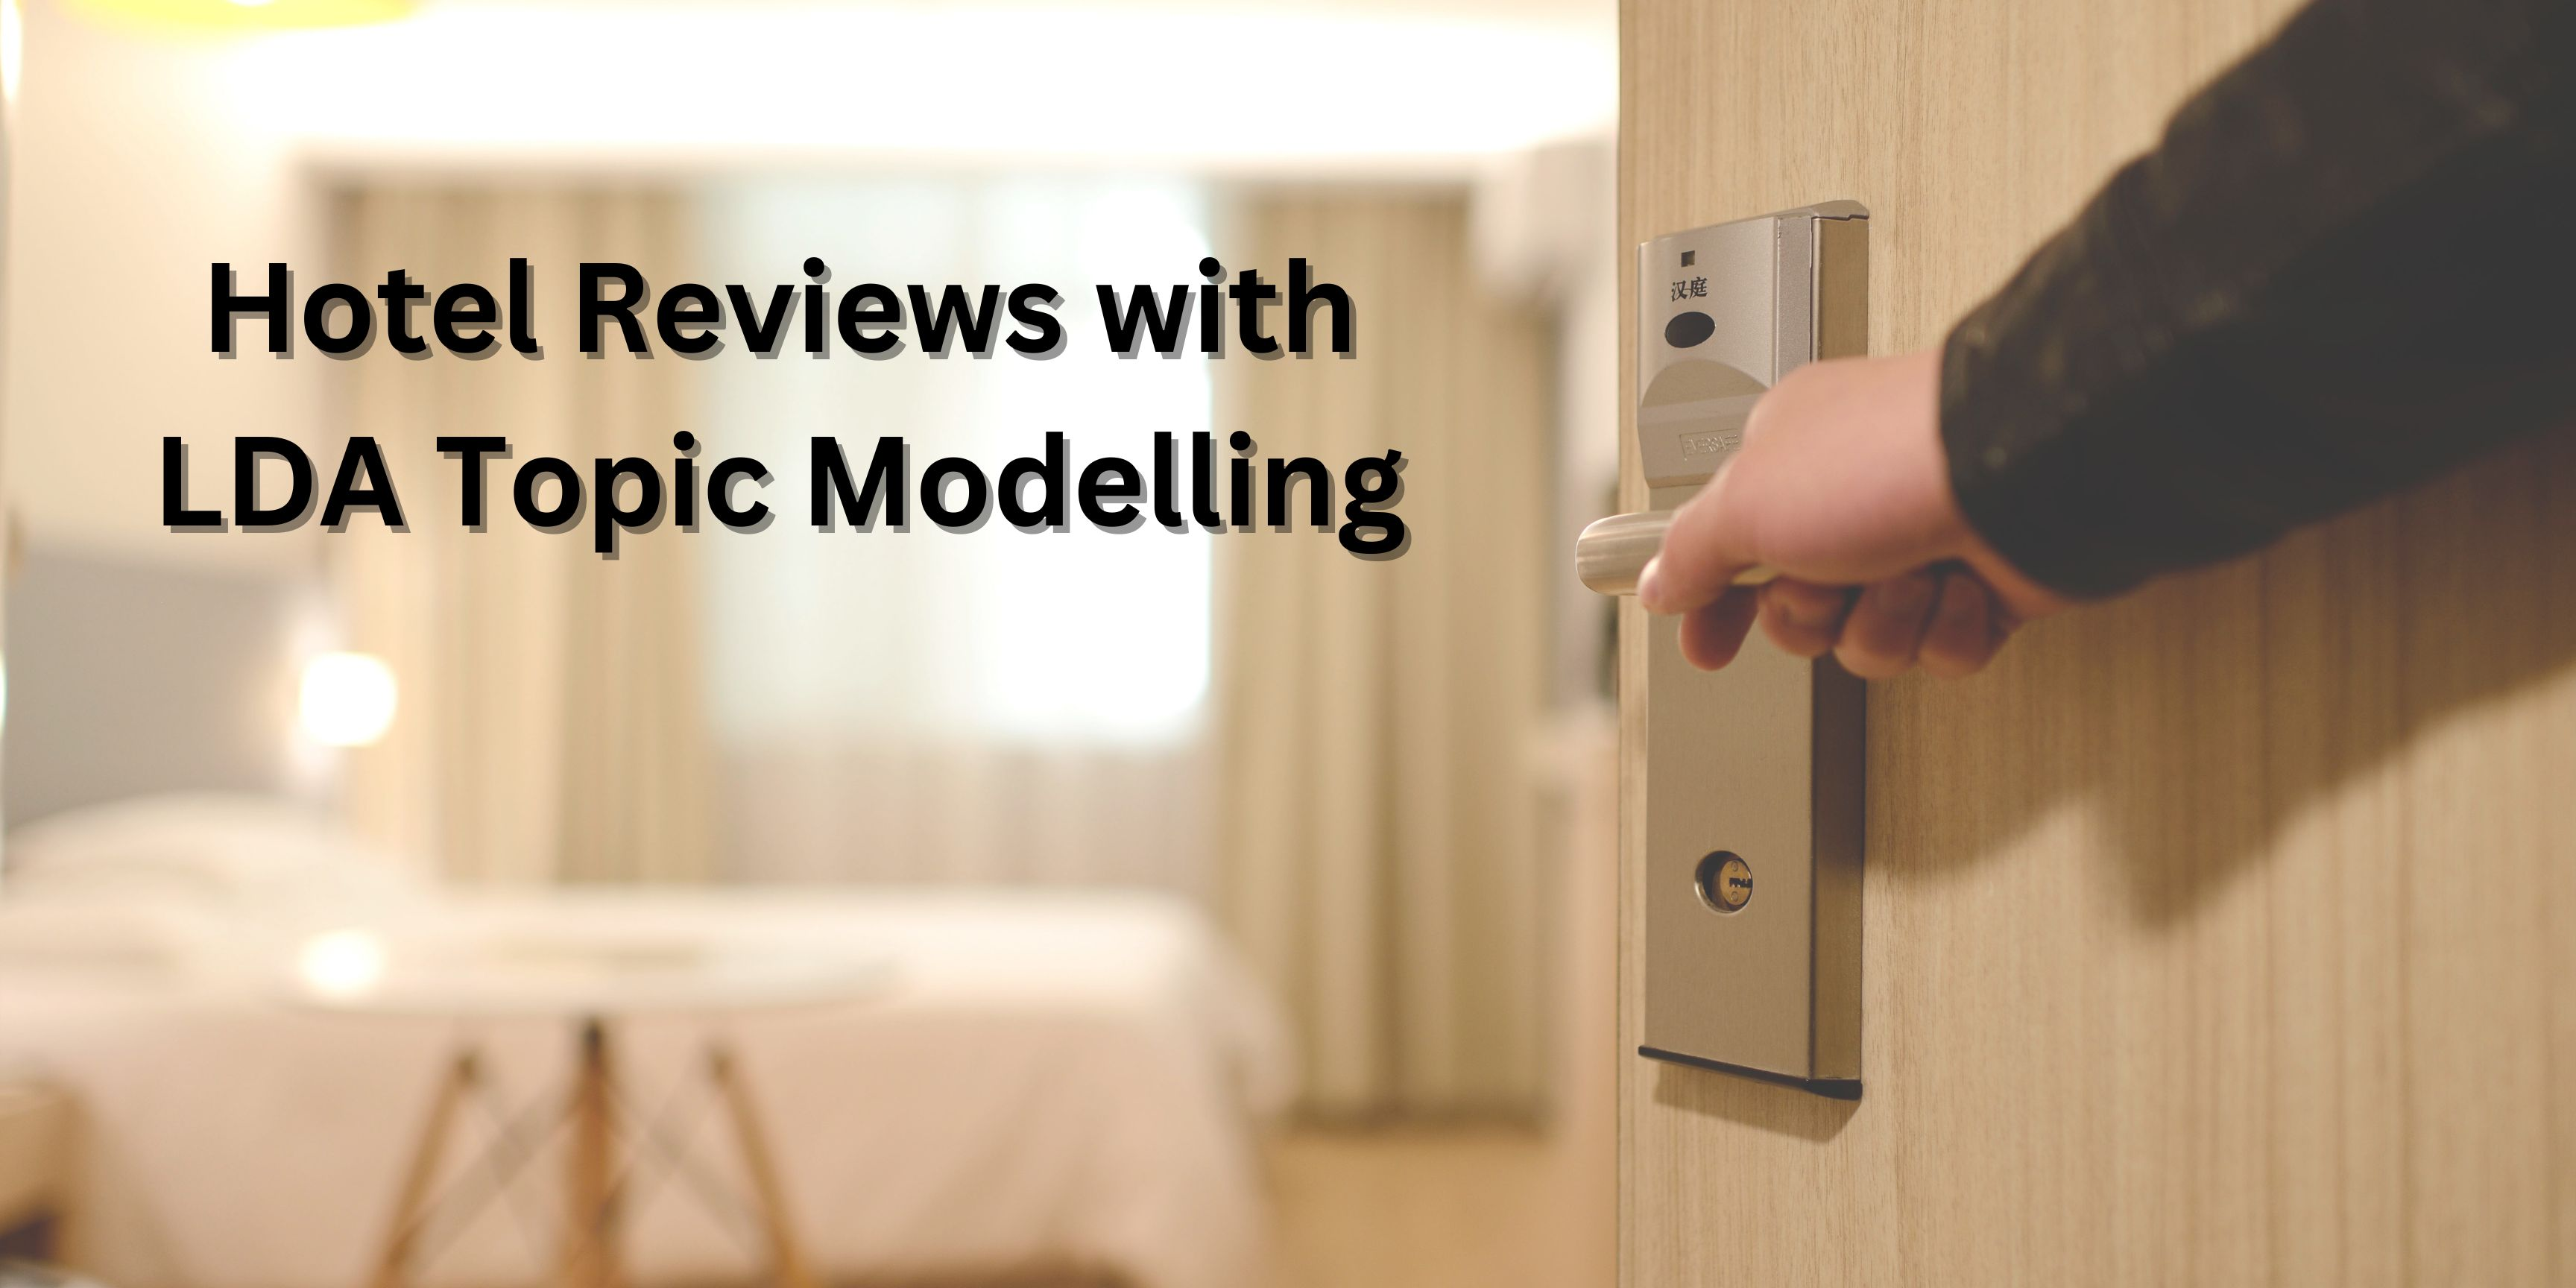

### Source of Dataset

Kaggle: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews?select=tripadvisor_hotel_reviews.csv

### Analysis Workflow

This notebook analyzes a dataset of 20,000 hotel reviews from Tripadvisor using Latent Dirichlet Allocation (LDA) for topic modeling. The primary objective is to leverage machine learning techniques to identify potential topics in the lowest-rated reviews, providing insights into areas where hotels may need improvement. Additionally, the analysis aims to uncover topics from the highest-rated reviews, highlighting aspects that contribute to a satisfying customer experience. The text processing steps include removing stopwords and punctuation, lemmatization, and vectorization, which are essential pre-processing steps before applying LDA topic modeling.

### Import the Essential Dependencies

In [1]:
# import essential dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Load the Dataset

In [2]:
# load the dataset
data = pd.read_csv('../data/tripadvisor_hotel_reviews.csv')

# check the dimension of the dataset
numrow, numcol = data.shape
print('The dataset contains {} rows and {} columns.'.format(numrow, numcol))

# check the attributes in the dataset
attributes = data.columns.values
print('Attributes in the dataset:', attributes)

# display the first 5 rows of the dataset
data.head()

The dataset contains 20491 rows and 2 columns.
Attributes in the dataset: ['Review' 'Rating']


Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

### Summary of Dataset

In [3]:
# summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [4]:
# check for duplicates and missing value 
print('Number of duplicates record in the dataset:', data.duplicated().sum())
print('Number of mising value in the dataset:')
print(data.isna().sum())

Number of duplicates record in the dataset: 0
Number of mising value in the dataset:
Review    0
Rating    0
dtype: int64


### Exploratory Data Analysis (EDA)

In [5]:
# distribution of the rating
rating_cat = data['Rating'].nunique()
rating = data['Rating'].unique()

print(f'There are {rating_cat} category of rating in the dataset.')
print('These ratings are:', rating)

There are 5 category of rating in the dataset.
These ratings are: [4 2 3 5 1]


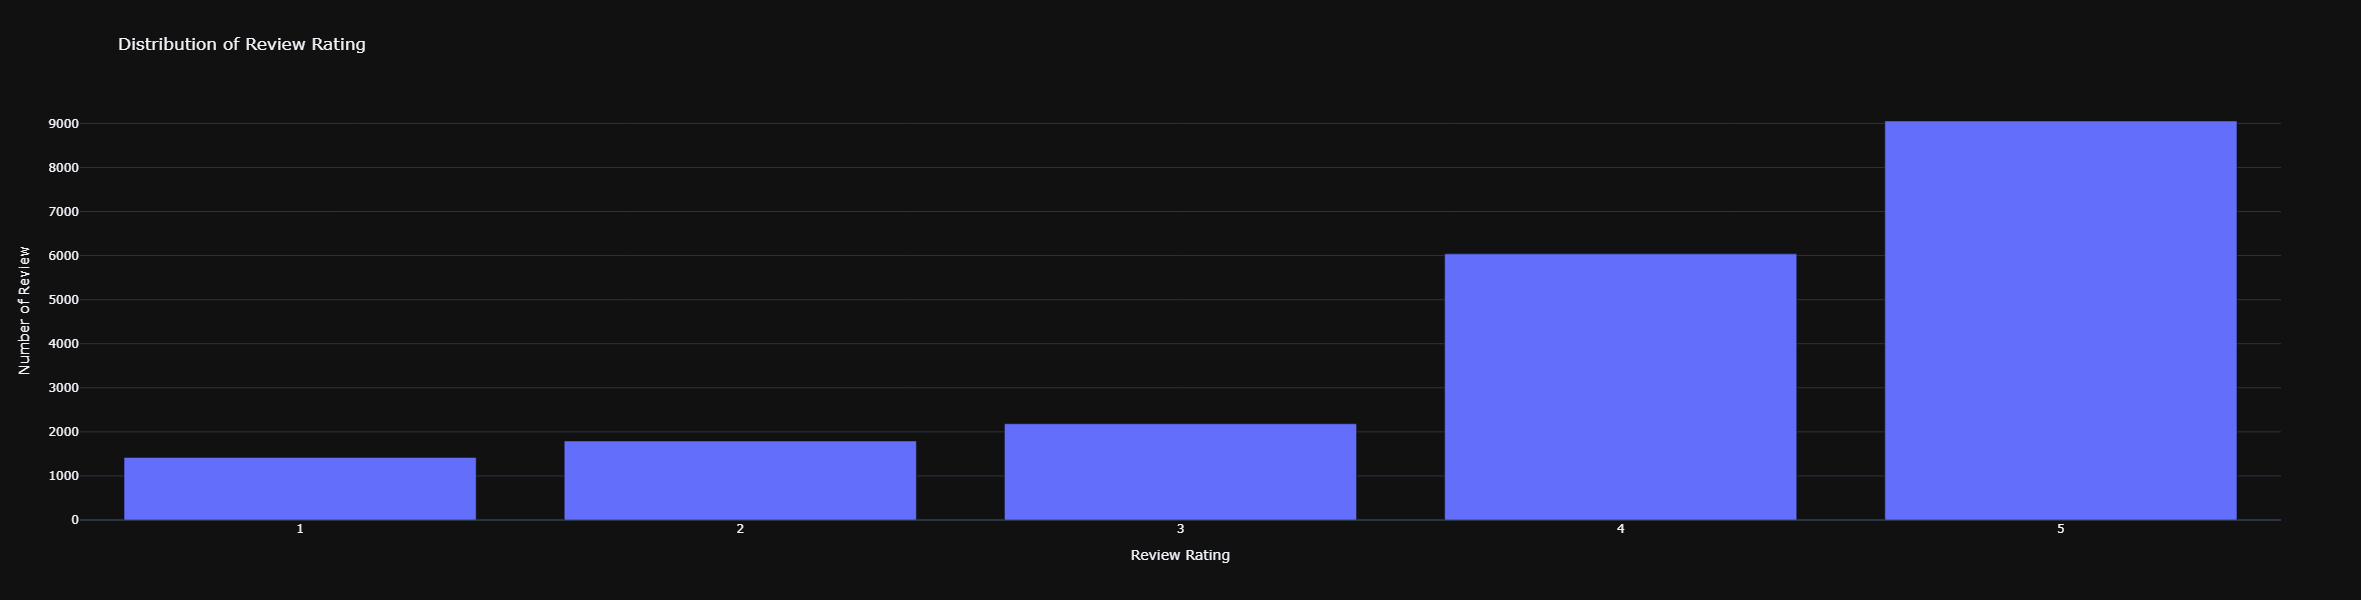

In [6]:
rating_count = data['Rating'].value_counts().sort_index()
rating_count_df = pd.DataFrame(rating_count).reset_index()
rating_count_df.columns = ['Rating', 'Count']

fig = px.bar(rating_count_df, x=rating_count_df['Rating'], y=rating_count_df['Count'], width=800, height=600, template='plotly_dark', title='Distribution of Review Rating')
fig.update_layout(
    xaxis = dict(
        title = 'Review Rating'
    ),
    yaxis = dict(
        title = 'Number of Review'
    )
)
fig.show()

In [7]:
# additional 2 columns = total number of sentence and total  umber of words in the review text
from nltk.tokenize import sent_tokenize, word_tokenize 

data['Sentence_Number'] = data['Review'].apply(lambda x: len(sent_tokenize(x)))
data['Word_Number'] = data['Review'].apply(lambda x: len(word_tokenize(x)))

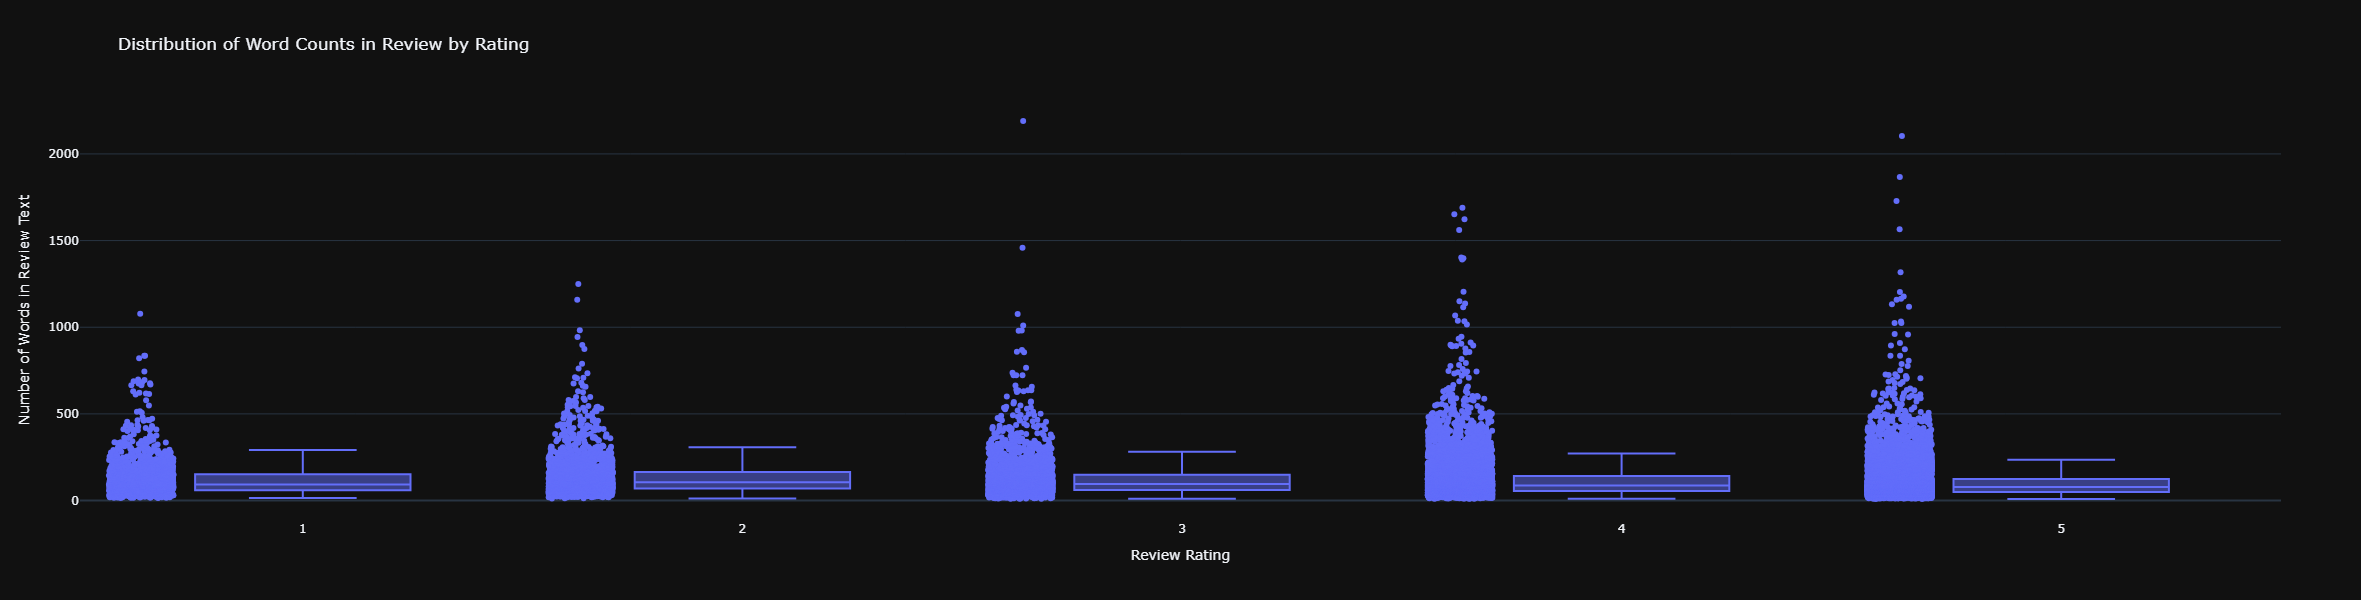

In [8]:
fig = px.box(data, x='Rating', y='Word_Number', points='all', width=1000, height=600, template='plotly_dark', title='Distribution of Word Counts in Review by Rating')
fig.update_layout(
    xaxis = dict(
        title = 'Review Rating'
    ),
    yaxis = dict(
        title = 'Number of Words in Review Text'
    )
)
fig.show()

### Text Processing

In [9]:
# define a function to normalize the review text (remove stopwords, punctuation, lemmatization)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

lemmatizer = WordNetLemmatizer()

stopwords = stopwords.words('english')
pattern = r'[^\w\s]' #  matches any character that is not a word character (\w) or whitespace (\s)

def text_normalization(text):
    texts = re.sub(pattern, '', text)
    tokens = word_tokenize(texts)
    fil_tokens = [token for token in tokens if token.lower() not in stopwords]
    fil_tokens_lemma = [lemmatizer.lemmatize(token) for token in fil_tokens]
    joined_text = ' '.join(map(str, fil_tokens_lemma))
    return joined_text

In [10]:
# insert an additional column with the normalized review text
data['Cleaned_Text'] = data['Review'].apply(lambda x: text_normalization(x))

In [11]:
# define a function to extract text feature 
from sklearn.feature_extraction.text import CountVectorizer

def vectorization(df):
    # the vectorizer object will be used to transform text to vector form
    vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

    # apply transformation
    tf = vectorizer.fit_transform(df['Cleaned_Text']).toarray()

    # tf_feature_names tells us what word each column in the matric represents
    tf_feature_names = vectorizer.get_feature_names_out()
    
    return tf, tf_feature_names

In [12]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [13]:
# define a function to perform topic modelling based on the selected review rating
from sklearn.decomposition import LatentDirichletAllocation

def topic_modelling(df, rating, number_of_topics, no_top_words):
    selected_df = df[df['Rating']==rating]
    tf, tf_feature_names = vectorization(selected_df)
    model = LatentDirichletAllocation(n_components=number_of_topics, random_state=122)
    model.fit(tf)
    return display_topics(model, tf_feature_names, no_top_words)

### Topic Modelling

#### Lowest Rating Reviews

In [14]:
# let's check the top 5 topics for the lowest rating
lowest_rate = topic_modelling(data, 1, 5, 10)
display(lowest_rate)

Topic 0 words Topic 0 weights Topic 1 words Topic 1 weights Topic 2 words  \
0         hotel          1256.1       service           218.4         hotel   
1          room           832.1         hotel           216.2          room   
2          told           423.0    restaurant           176.3          stay   
3          stay           401.1          food           145.8         place   
4           day           328.0           bar            97.3            nt   
5          desk           323.4          pool            94.5        stayed   
6       manager           314.3         beach            89.6          star   
7            nt           285.3     breakfast            87.1         staff   
8       service           276.3         guest            85.3         dirty   
9         night           271.2           san            85.2          like   

  Topic 2 weights Topic 3 words Topic 3 weights Topic 4 words Topic 4 weights  
0          1202.3          room          1864.8          room           657.6  
1           749.7         hotel          1148.0        resort           644.9  
2           371.3         night           523.3            nt           617.4  
3           318.1            nt           414.6           day           514.3  
4           312.0           bed           379.8          food           431.9  
5           249.3          stay           311.0         beach           367.5  
6           230.6          door           260.0          time           344.4  
7           224.7         staff           232.8           got           284.6  
8           223.9      bathroom           216.3        people           257.0  
9           218.2        booked           199.3          good           248.6

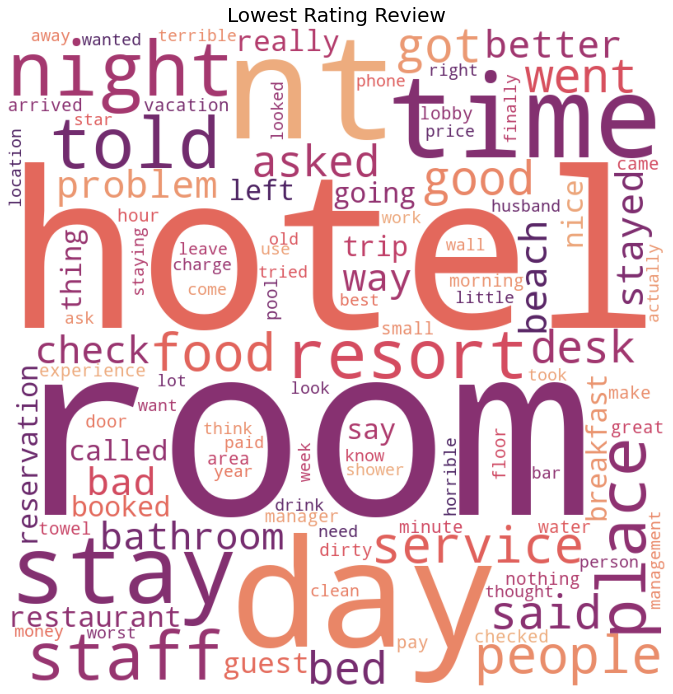

In [15]:
from wordcloud import WordCloud

data_low = data[data['Rating']==1]
combined_text_low = ' '.join(data_low['Cleaned_Text'])


# create a word cloud using the combined text
wordcloud_title = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            colormap = 'flare',
                            min_font_size = 15).generate(combined_text_low)

# plot the WordCloud image
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_title)
plt.axis('off')
plt.title('Lowest Rating Review', fontsize=20)
plt.tight_layout(pad=2)
plt.show()

#### Highest Rating Reviews

In [16]:
# let's check the top 5 topics for the highest rating
highest_rate = topic_modelling(data, 5, 5, 10)
display(highest_rate)

Topic 0 words Topic 0 weights Topic 1 words Topic 1 weights Topic 2 words  \
0         hotel          8981.3         hotel          5188.3          room   
1          room          5069.4          room          3189.4            nt   
2         great          2356.2         staff          2141.0         hotel   
3          good          2081.3       service          1866.5          nice   
4     breakfast          1952.9          stay          1843.9          pool   
5      location          1930.5         great          1201.3         night   
6         staff          1705.0        stayed          1197.3         great   
7     excellent          1544.5          time           926.1           day   
8          walk          1528.7          best           901.7          area   
9         night          1425.6          view           841.6     breakfast   

  Topic 2 weights Topic 3 words Topic 3 weights Topic 4 words Topic 4 weights  
0          3306.2         hotel          7399.6         beach          3164.2  
1          1635.4         great          3928.2        resort          3016.7  
2          1398.8          room          3466.9         great          2334.5  
3          1122.9          stay          2601.1            nt          2050.1  
4          1014.7      location          2456.8          food          2012.0  
5          1007.0         staff          2335.6          time          1966.6  
6           856.8         clean          1485.4          pool          1954.0  
7           856.6        stayed          1426.6           day          1869.3  
8           818.3         place          1305.4          room          1769.1  
9           813.1      friendly          1287.3          good          1735.4

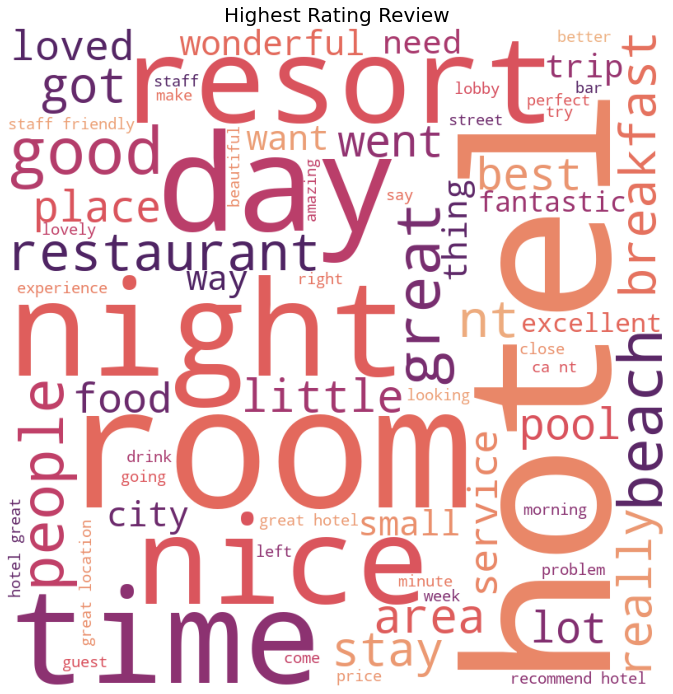

In [17]:
data_low = data[data['Rating']==5]
combined_text_high = ' '.join(data_low['Cleaned_Text'])


# create a word cloud using the combined text
wordcloud_title = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            colormap = 'flare',
                            min_font_size = 15).generate(combined_text_high)

# plot the WordCloud image
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_title)
plt.axis('off')
plt.title('Highest Rating Review', fontsize=20)
plt.tight_layout(pad=2)
plt.show()

### Potential Topics 

Based on the provided keywords for the lowest and highest ratings, here are the possible topics that can be assigned:

**Lowest Rating (1-star reviews)**
1. **Topic 1:** Issues with Hotel Staff and Management
   - Keywords: hotel, room, told, stay, day, desk, manager, nt, service, night
   - Explanation: This topic seems to focus on problems related to interactions with hotel staff and management, including being told things, dealing with the desk and manager, and issues occurring during the stay.


2. **Topic 2:** Poor Service and Amenities
   - Keywords: service, hotel, restaurant, food, bar, pool, beach, breakfast, guest, san
   - Explanation: The focus here is on the overall poor service and amenities, including negative experiences at the restaurant, bar, pool, and beach, as well as poor breakfast service.


3. **Topic 3:** Unpleasant Stay and Dirty Conditions
   - Keywords: hotel, room, stay, place, nt, stayed, star, staff, dirty, like
   - Explanation: This topic likely addresses general dissatisfaction with the stay, highlighting dirty conditions, and overall poor experiences with the hotel and staff.


4. **Topic 4:** Issues with Room Quality and Maintenance
   - Keywords: room, hotel, night, nt, bed, stay, door, staff, bathroom, booked
   - Explanation: This topic seems to be focused on specific issues within the rooms, such as bed quality, bathroom conditions, and problems with doors, leading to a negative stay.


5. **Topic 5:** Disappointment with Resort Experience
   - Keywords: room, resort, nt, day, food, beach, time, got, people, good
   - Explanation: This topic might capture overall disappointment with the resort, including dissatisfaction with the rooms, food, and beach, as well as the overall experience.

**Highest Rating (5-star reviews)**
1. **Topic 1:** Excellent Hotel Experience
   - Keywords: hotel, room, great, good, breakfast, location, staff, excellent, walk, night
   - Explanation: This topic highlights a generally excellent hotel experience, with mentions of great rooms, good breakfast, excellent staff, and a good location.


2. **Topic 2:** Exceptional Staff and Service
   - Keywords: hotel, room, staff, service, stay, great, stayed, time, best, view
   - Explanation: The focus here is on the outstanding service and staff, with mentions of great stays and possibly nice views.


3. **Topic 3:** Enjoyable Amenities and Relaxation
   - Keywords: room, nt, hotel, nice, pool, night, great, day, area, breakfast
   - Explanation: This topic emphasizes enjoyable amenities such as the pool and breakfast, as well as general relaxation and comfort during the stay.


4. **Topic 4:** Cleanliness and Friendly Staff
   - Keywords: hotel, great, room, stay, location, staff, clean, stayed, place, friendly
   - Explanation: This topic likely highlights the cleanliness of the hotel and rooms, as well as the friendliness of the staff and a good location.


5. **Topic 5:** Great Resort and Beach Experience
   - Keywords: beach, resort, great, nt, food, time, pool, day, room, good
   - Explanation: The focus here is on a positive resort experience, with great beach access, good food, and enjoyable time spent at the pool and resort overall.